# Predicción de Grasa Corporal

## Este es un modelo de análisis multivariado para predecir la grasa corporal en base a diferentes medidas del cuerpo de los individuos, usaremos modelos de Machine Learning y vamos a analizar sus performance

In [4]:
# Importamos librerias a un pco inusuales

!pip install pingouin
!pip install sklearn-genetic-opt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas.plotting import andrews_curves
from scipy.cluster.hierarchy import linkage, dendrogram
from pingouin import multivariate_normality
from scipy.stats import chi2
from sklearn.neighbors import KernelDensity
from os import pipe
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Continuous
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
# Importamos el acceso a los datos de la Unidad (en caso de drive)

# from google.colab import drive
# drive.mount('/content/drive')

# path a unidad de drive

# path = '/content/drive/My Drive/Practica 2 Analisis Multivariado/'

# Declaramos el path local (en caso de trabajar localmente)

path = './'

# Declaramos los datos en un df

df = pd.read_csv(path + 'bodyfat.csv')

## 1. Entrada de los Datos

Dados los datos entregdos por el profesor

*   BodyFat: Porcentaje de grasa corporal
*   Age: Edad de la persona.
*   Weight: Peso.
*   Height: Altura.
*   Neck: Perímetro del cuello.
*   Chest: Perímetro del pecho.
*   Abdomen: Perímetro del abdomen.
*   Hip: Perímetro de la cadera.
*   Thigh: Perímetro del muslo.
*   Knee: Perímetro de la rodilla.
*   Ankle: Perímetro del tobillo.
*   Biceps: Perímetro del bíceps.
*   Forearm: Perímetro del antebrazo.
*   Wrist: Perímetro de la muñeca.

In [6]:
# Imprimos como se ve el df

df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [7]:
# Mas informacion del df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


In [8]:
# Separar variables sin alterar el df original

variables = df.columns.difference(["Density"])
datos = df[variables].copy()

In [9]:
# var de bodyfat

labels = [
    "Extremadamente bajo",
    "Muy bajo",
    "Ligeramente bajo",
    "Neutral",
    "Ligeramente alto",
    "Muy alto",
    "Extremo"
]

datos["BodyFat_discretizada"] = pd.qcut(
    datos["BodyFat"],
    q=7,
    labels=labels
)

In [10]:
# Tipos de datos
tipo = datos.dtypes

# Numéricas
continuas = tipo[tipo == "float64"].index.tolist()
enteras = tipo[tipo == "int64"].index.tolist()
numericas = continuas + enteras

# Categóricas
categoricas = datos.select_dtypes(include=["object", "category"]).columns.tolist()

# Target y predictores
target = "BodyFat"
predictores = [c for c in datos.columns if c != target]

In [11]:
# Indices

datos.index = datos.index.astype(str)
indices = datos.index

In [12]:
# Separacion de datos en 80-20

obs_train, obs_test = train_test_split(
    datos.index,
    test_size=0.2,
    random_state=123
)

In [13]:
# Imprimimos el nuevo df

datos.head()

,Abdomen,Age,Ankle,Biceps,BodyFat,Chest,Forearm,Height,Hip,Knee,Neck,Thigh,Weight,Wrist,BodyFat_discretizada
0,85.2,23,21.9,32.0,12.3,93.1,27.4,67.75,94.5,37.3,36.2,59.0,154.25,17.1,Muy bajo
1,83.0,22,23.4,30.5,6.1,93.6,28.9,72.25,98.7,37.3,38.5,58.7,173.25,18.2,Extremadamente bajo
2,87.9,22,24.0,28.8,25.3,95.8,25.2,66.25,99.2,38.9,34.0,59.6,154.00,16.6,Muy alto
3,86.4,26,22.8,32.4,10.4,101.8,29.4,72.25,101.2,37.3,37.4,60.1,184.75,18.2,Muy bajo
4,100.0,24,24.0,32.2,28.7,97.3,27.7,71.25,101.9,42.2,34.4,63.2,184.25,17.7,Extremo


## 2. Exploratorio de datos

In [14]:
# Un analisis medio general de las columnas

datos.loc[obs_train].describe()

,Abdomen,Age,Ankle,Biceps,BodyFat,Chest,Forearm,Height,Hip,Knee,Neck,Thigh,Weight,Wrist
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,92.390547,45.253731,22.991542,32.104478,19.317413,100.631841,28.538308,69.927861,99.657214,38.482587,37.931343,59.220896,177.690547,18.190547
std,10.936264,12.875181,1.576476,2.993665,8.382216,8.455470,2.015583,3.885118,7.420112,2.409947,2.450482,5.326684,29.734857,0.954023
min,69.400000,22.000000,19.100000,25.300000,0.000000,79.300000,21.000000,29.500000,85.000000,33.000000,31.100000,47.200000,118.500000,15.800000
25%,85.200000,36.000000,22.000000,30.100000,12.500000,94.600000,27.300000,68.000000,95.200000,36.900000,36.300000,56.000000,158.000000,17.400000
50%,90.600000,44.000000,22.700000,31.700000,19.500000,99.400000,28.700000,70.000000,98.700000,38.400000,38.000000,58.900000,173.750000,18.200000
75%,99.200000,54.000000,23.800000,34.100000,25.300000,105.300000,29.900000,72.000000,102.700000,39.800000,39.200000,61.900000,195.750000,18.800000
max,148.100000,81.000000,33.900000,45.000000,47.500000,136.200000,34.900000,77.750000,147.700000,49.100000,51.200000,87.300000,363.150000,21.400000


In [15]:
# Variables con varianza cero?

variances = datos.loc[obs_train, numericas].var()
variances[variances == 0]

Series([], dtype: float64)

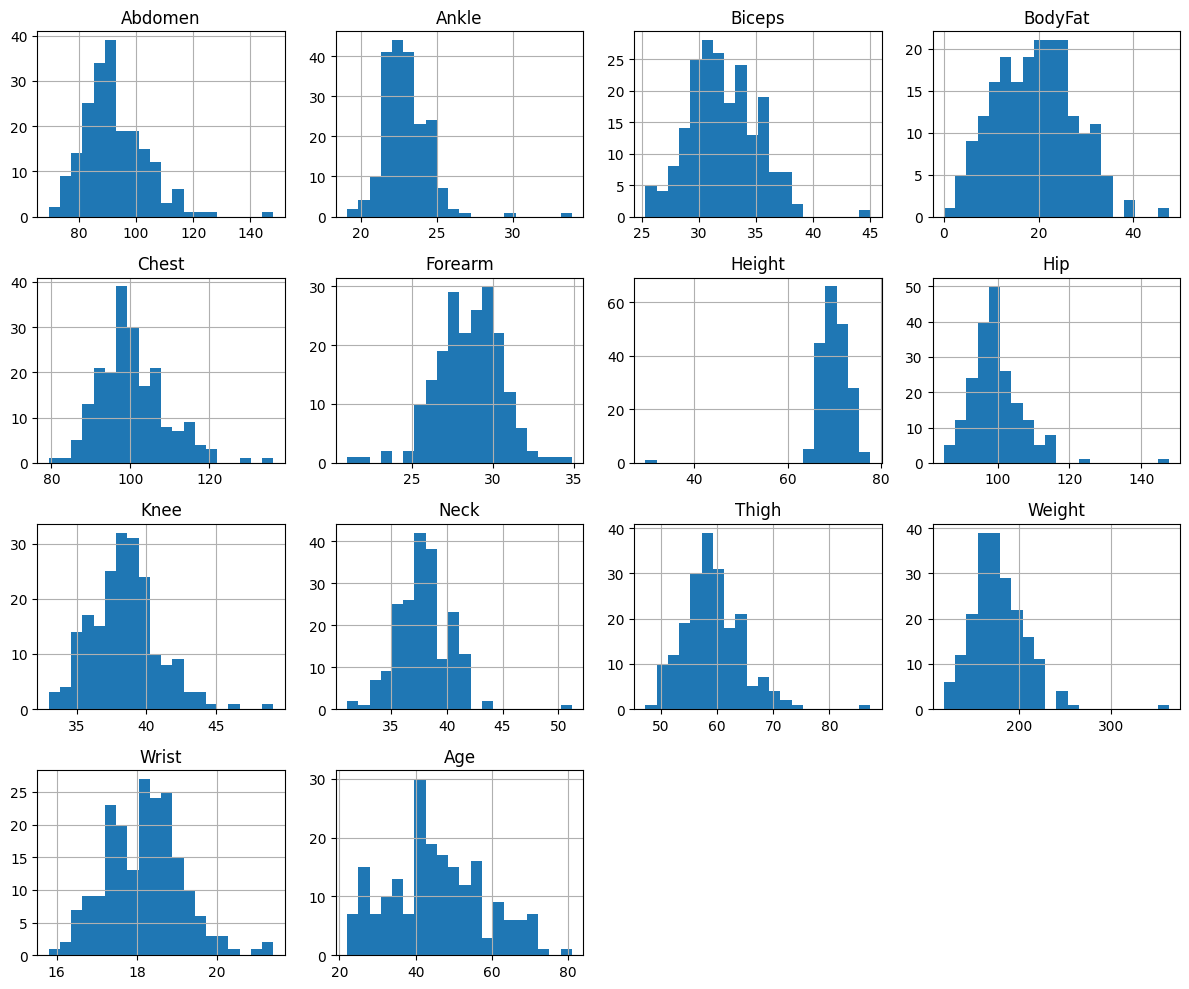

In [16]:
# Histograma de todas las columnas

datos.loc[obs_train, numericas].hist(
    figsize=(12,10),
    bins=20
)
plt.tight_layout()
plt.show()

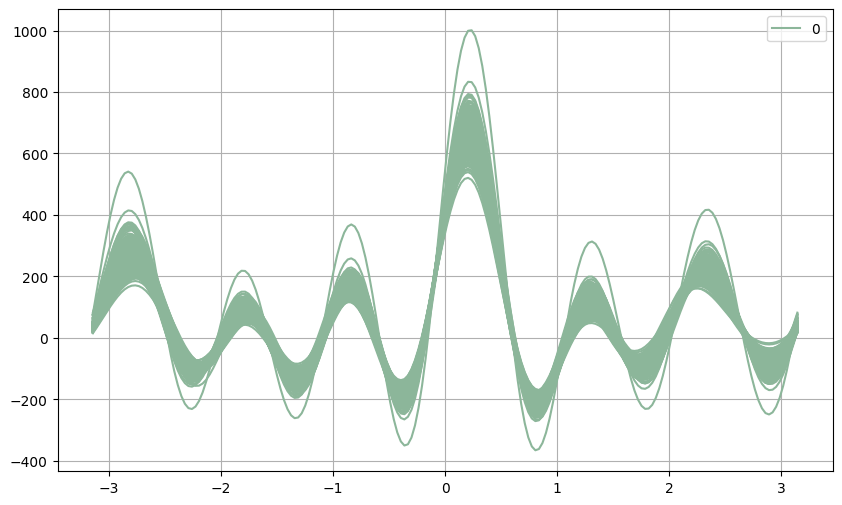

In [17]:

fig, ax = plt.subplots(figsize=(10, 6))
andrews_curves(
    datos.loc[obs_train, numericas].assign(dummy=0),
    class_column="dummy",
    ax=ax
)
plt.show()


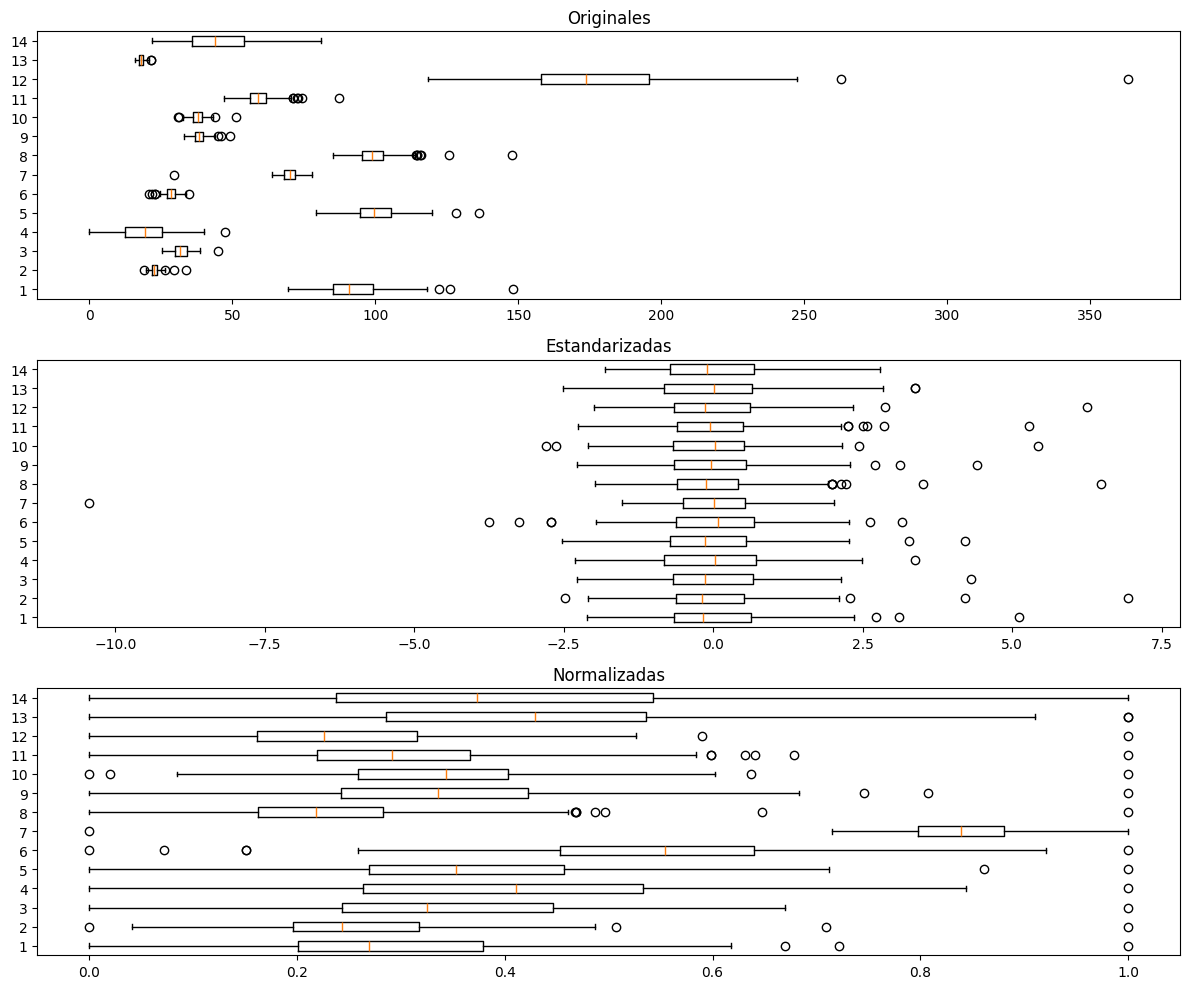

In [18]:

X = datos.loc[obs_train, numericas]

X_std = pd.DataFrame(
    StandardScaler().fit_transform(X),
    columns=X.columns
)

X_norm = pd.DataFrame(
    MinMaxScaler().fit_transform(X),
    columns=X.columns
)

fig, axs = plt.subplots(3,1, figsize=(12,10))
axs[0].boxplot(X, vert=False); axs[0].set_title("Originales")
axs[1].boxplot(X_std, vert=False); axs[1].set_title("Estandarizadas")
axs[2].boxplot(X_norm, vert=False); axs[2].set_title("Normalizadas")
plt.tight_layout()
plt.show()

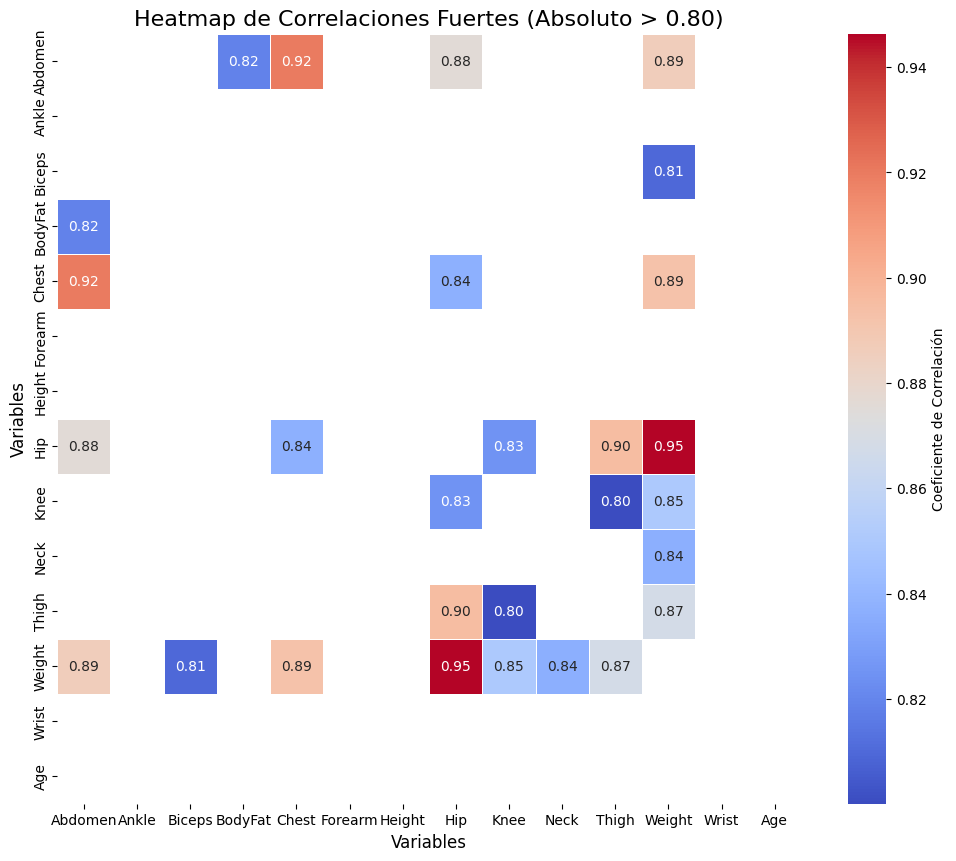

In [19]:
corr = datos.loc[obs_train, numericas].corr()

filtered_strong_corr = corr[(corr.abs() > 0.80) & (corr.abs() < 1.0)]

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    filtered_strong_corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Coeficiente de Correlación'}
)
plt.title('Heatmap de Correlaciones Fuertes (Absoluto > 0.80)', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.show()

/var/folders/1v/dh72m30s377gjf7zw07mqrhw0000gn/T/ipykernel_40738/2083767298.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist, method="average")


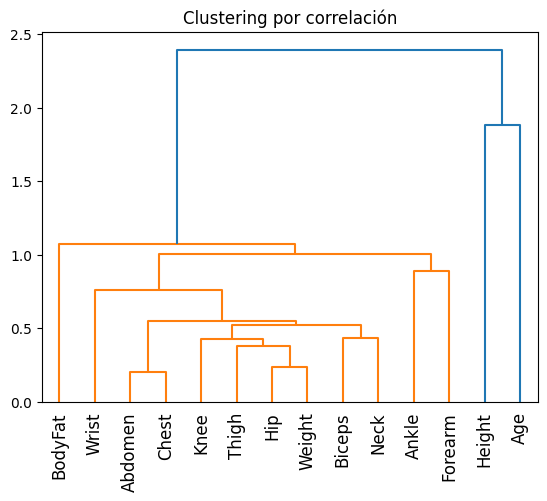

In [20]:
dist = 1 - corr
Z = linkage(dist, method="average")
dendrogram(Z, labels=corr.columns, leaf_rotation=90)
plt.title("Clustering por correlación")
plt.show()


In [21]:
multivariate_normality(
    datos.loc[obs_train, numericas].dropna(),
    alpha=0.05
)

HZResults(hz=1.0607886309035082, pval=3.91693908890089e-89, normal=False)

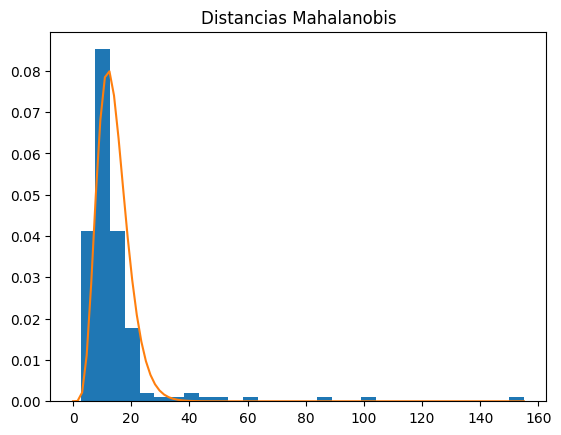

In [22]:
X = datos.loc[obs_train, numericas].dropna()
mean = X.mean().values
cov = np.cov(X.T)

inv_cov = np.linalg.inv(cov)
diff = X.values - mean
mahal = np.sum(diff @ inv_cov * diff, axis=1)

plt.hist(mahal, bins=30, density=True)
x = np.linspace(0, mahal.max(), 100)
plt.plot(x, chi2.pdf(x, df=X.shape[1]))
plt.title("Distancias Mahalanobis")
plt.show()


## 3. Preprocesamiento

In [23]:
df = datos.copy()

def outliers_kde(x, alpha=0.05, bandwidth='scott'):
    x = x.dropna().values.reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(x)
    log_dens = kde.score_samples(x)
    dens = np.exp(log_dens)

    umbral = np.quantile(dens, alpha)
    outliers = dens < umbral

    return {
        "densidades": dens,
        "outliers": outliers,
        "umbral": umbral,
        "kde_model": kde
    }

In [24]:
atipicos = {}
densidades_kde = {}
atipicos_tabla = []

for var in numericas:
    obj = outliers_kde(df[var], alpha=0.05)

    obs_out = df.index[obj["outliers"]]
    atipicos[var] = df.loc[obs_out, var]

    atipicos_tabla.extend(obs_out)
    densidades_kde[var] = obj

atipicos_tabla = pd.Series(atipicos_tabla).value_counts()
atipicos_tabla.head()

38     11
181    10
40     10
225     7
34      6
Name: count, dtype: int64

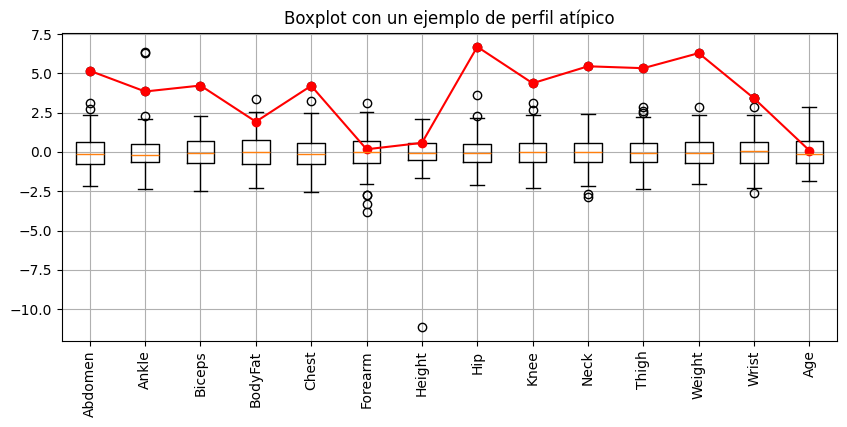

In [30]:
def escalar_datos(df_to_scale, modo="original"):
    if modo == "original":
        return df_to_scale.copy()
    if modo == "standard":
        return pd.DataFrame(StandardScaler().fit_transform(df_to_scale),
                            columns=df_to_scale.columns, index=df_to_scale.index)
    if modo == "minmax":
        return pd.DataFrame(MinMaxScaler().fit_transform(df_to_scale),
                            columns=df_to_scale.columns, index=df_to_scale.index)

obs = atipicos_tabla.index[0]

datos_escalados = escalar_datos(df[numericas], modo="standard")

plt.figure(figsize=(10,4))
plt.boxplot(datos_escalados.values, labels=datos_escalados.columns)
plt.plot(range(1, len(numericas)+1),
         datos_escalados.loc[obs], 'ro-')
plt.xticks(rotation=90)
plt.title("Boxplot con un ejemplo de perfil atípico")
plt.grid(True)
plt.show()

In [31]:
df_imputado = df.copy()

for var in numericas:
    obs_out = atipicos[var].index
    df_imputado.loc[obs_out, var] = np.nan

    M = len(obs_out)
    if M == 0:
        continue

    kde = densidades_kde[var]["kde_model"]
    simulaciones = kde.sample(M).flatten()

    df_imputado.loc[obs_out, var] = simulaciones


In [32]:
# Atipicos pero multivariados

# Seleccionar solo las columnas numéricas antes de calcular la media y la covarianza
X = df_imputado[numericas].dropna()
mu = X.mean().values
cov = np.cov(X.values, rowvar=False)
inv_cov = np.linalg.inv(cov)

def mahalanobis(x, mu, inv_cov):
    d = x - mu
    return np.sqrt(np.dot(np.dot(d, inv_cov), d.T))

distancias = X.apply(lambda row: mahalanobis(row.values, mu, inv_cov), axis=1)

umbral = np.sqrt(chi2.ppf(0.99, df=X.shape[1]))

atipicos_mult = distancias[distancias > umbral]
atipicos_mult.head()


21    5.619418
26    7.079762
34    7.142416
35    5.411608
38    6.975136
dtype: float64

## 4. Aplicar modelo no lineal

In [42]:
# Con el analisis anterior, tenemos dos opciones usuales

# Eliminar
df_final = df_imputado.drop(index=atipicos_mult.index)

# Imputar
# Aseguramos que solo las columnas numéricas sean imputadas con su media
df_imputado.loc[atipicos_mult.index, numericas] = df_imputado[numericas].mean().values


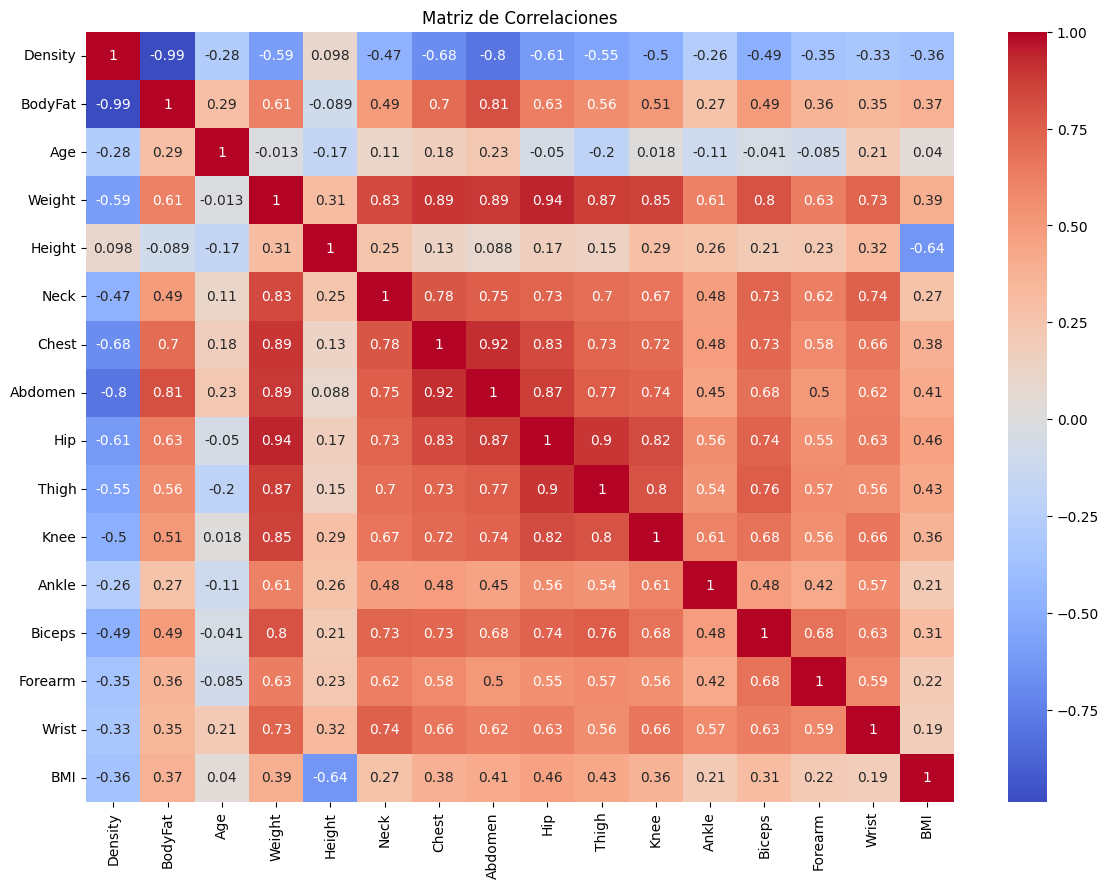

In [43]:
df = pd.read_csv(path + 'bodyfat.csv')

# Creamos una variable sintetica

df['BMI']=df['Weight']/(df['Height']*df['Height'])

# Seleccionamos solo las columnas numéricas para el cálculo de la correlación
numeric_df = df.select_dtypes(include=np.number)

# Veamos otra vez la matriz de correlacion
plt.figure(figsize=(14,10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaciones')
plt.show()


In [ ]:
# Pair plot de las caracteristicas
selected_features = ['BodyFat', 'Wrist', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'BMI']
sns.pairplot(df[selected_features])
plt.show()

# Nuevo df con con las selected_features

df = df[selected_features]

KeyboardInterrupt: 

In [ ]:
# Definimos el target
X = df.drop(columns=['BodyFat'])
y = df['BodyFat']

# Train-test split vamos 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalamos a estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer

# Modelos
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(kernel='rbf')
}


# Hiperparametros
params = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3]
    },
    'SVR': {
        'C': [100, 120, 150],
        'gamma': ['auto', 0.01, 0.005, 0.001],
        'epsilon': [3, 2, 1, 0.1],
        'tol': [1e-1, 1e-2, 1e-3]
    }
}

best_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    grid = GridSearchCV(
        estimator=model,
        param_grid=params[name],
        cv=5 if name == 'RandomForest' else 6,
        scoring='r2',
        n_jobs=-1
    )

    grid.fit(X_train_scaled, y_train)

    best_models[name] = grid.best_estimator_

    print(f"Best params for {name}:")
    print(grid.best_params_)



Training RandomForest...
Best params for RandomForest:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Training SVR...
Best params for SVR:
{'C': 150, 'epsilon': 3, 'gamma': 0.005, 'tol': 0.01}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

    print(f"{name} Performance on Test Set:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2: {r2:.3f}\n")



RandomForest Performance on Test Set:
MAE: 3.008
RMSE: 3.873
R2: 0.678

SVR Performance on Test Set:
MAE: 2.980
RMSE: 3.569
R2: 0.726



In [ ]:
import pandas as pd

rf = best_models['RandomForest']

rf_importance = (
    pd.Series(rf.feature_importances_, index=X_train.columns)
    .sort_values(ascending=False)
)

print(rf_importance)

Abdomen    0.721424
Height     0.052522
BMI        0.045646
Chest      0.040224
Weight     0.036797
Hip        0.034961
Wrist      0.034587
Neck       0.033838
dtype: float64


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {}

for name, model in best_models.items():

    # Sobre train
    y_pred_train = model.predict(X_train_scaled)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)

    # Sobre test
    y_pred_test = model.predict(X_test_scaled)

    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)


    results[name] = {
        "TRAIN": {
            "MAE": mae_train,
            "RMSE": rmse_train,
            "R2": r2_train
        },
        "TEST": {
            "MAE": mae_test,
            "RMSE": rmse_test,
            "R2": r2_test
        }
    }


    print(f"{name} Desempeñ0:")
    print("TRAIN")
    print(f"  MAE: {mae_train:.3f}")
    print(f"  RMSE: {rmse_train:.3f}")
    print(f"  R2: {r2_train:.3f}")

    print("TEST")
    print(f"  MAE: {mae_test:.3f}")
    print(f"  RMSE: {rmse_test:.3f}")
    print(f"  R2: {r2_test:.3f}\n")


RandomForest Desempeñ0:
TRAIN
  MAE: 1.559
  RMSE: 1.920
  R2: 0.951
TEST
  MAE: 3.008
  RMSE: 3.873
  R2: 0.678

SVR Desempeñ0:
TRAIN
  MAE: 3.517
  RMSE: 4.280
  R2: 0.757
TEST
  MAE: 2.980
  RMSE: 3.569
  R2: 0.726



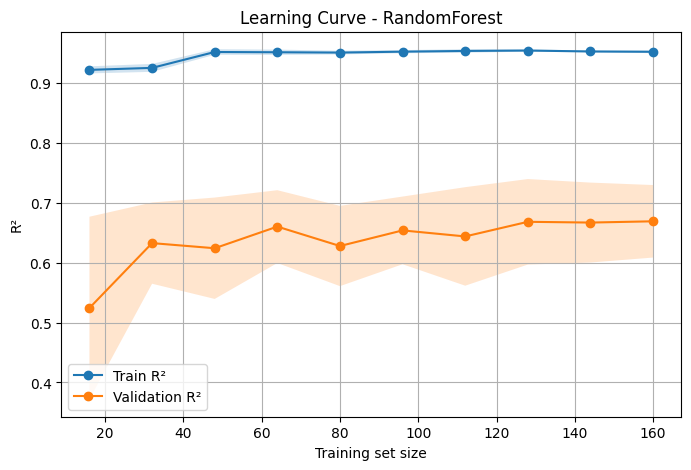

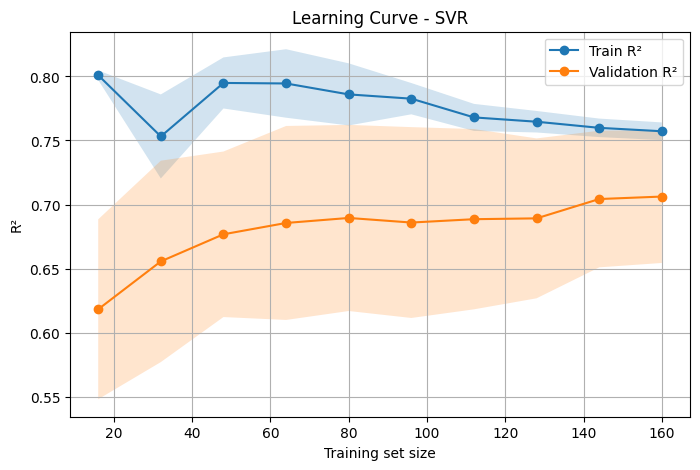

In [ ]:
# Queremos ver las curvas de aprendizaje

def plot_learning_curve(model, X, y, model_name):

    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,5))

    plt.plot(train_sizes, train_mean, 'o-', label="Train R²")
    plt.plot(train_sizes, val_mean, 'o-', label="Validation R²")

    plt.fill_between(train_sizes,
                     train_mean - train_std,
                     train_mean + train_std,
                     alpha=0.2)

    plt.fill_between(train_sizes,
                     val_mean - val_std,
                     val_mean + val_std,
                     alpha=0.2)

    plt.xlabel("Training set size")
    plt.ylabel("R²")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

for name, model in best_models.items():
    plot_learning_curve(model, X_train_scaled, y_train, name)


### Con el modelo de Random Forest, viendo los valores vemos un claro sobreajuste, por otro lado, con el Modelo SVR vemos un muy buen desempeño sin sobreajuste, este generaliza mejor y muestra una convergencia uniforme entre train y test.